# Forecast Model Analysis


In [1]:
import functions as sf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
df = pd.read_csv('../data/weight.csv')
df.index = pd.to_datetime(df['date'])
df = df.drop(['date'], axis=1)
df.head()

,weight_lbs,exer,food,avg_7d
date,,,,
2024-11-19,160.4,1,5,160.00
2024-11-20,159.2,1,6,160.00
2024-11-21,159.0,0,5,160.03
2024-11-22,159.2,1,6,159.86
2024-11-23,159.0,0,5,159.66


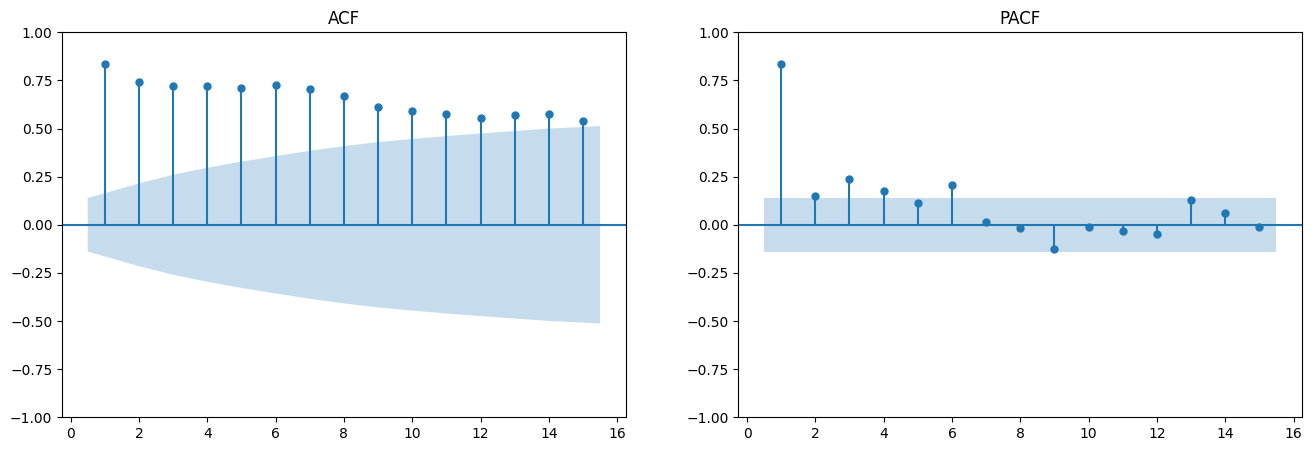

In [3]:
Y = df['weight_lbs']
sf.all_ac(Y)

In [4]:
sf.stationarity_test(Y)

('Non-Stationarity', 'Non-Stationarity')

/Users/danielferreira/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             weight_lbs   No. Observations:                  199
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -274.631
Date:                Thu, 05 Jun 2025   AIC                            557.262
Time:                        22:04:41   BIC                            570.415
Sample:                    11-19-2024   HQIC                           562.586
                         - 06-05-2025                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.3867      0.054     -7.224      0.000      -0.492      -0.282
ma.L1         -0.4181      0.065     -6.385      0.000      -0.546      -0.290
ma.L2         -0.2250      0.066     -3.409      0.0

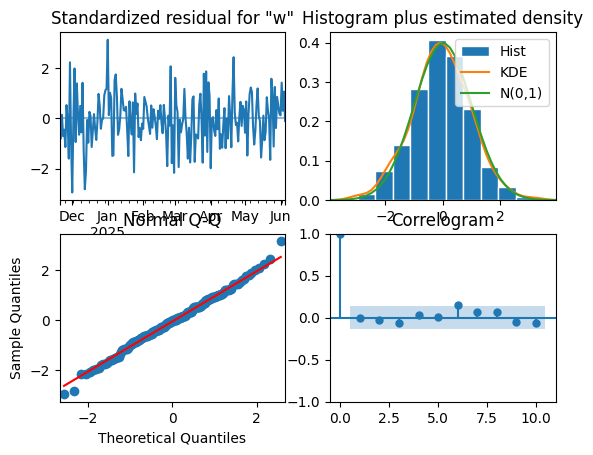

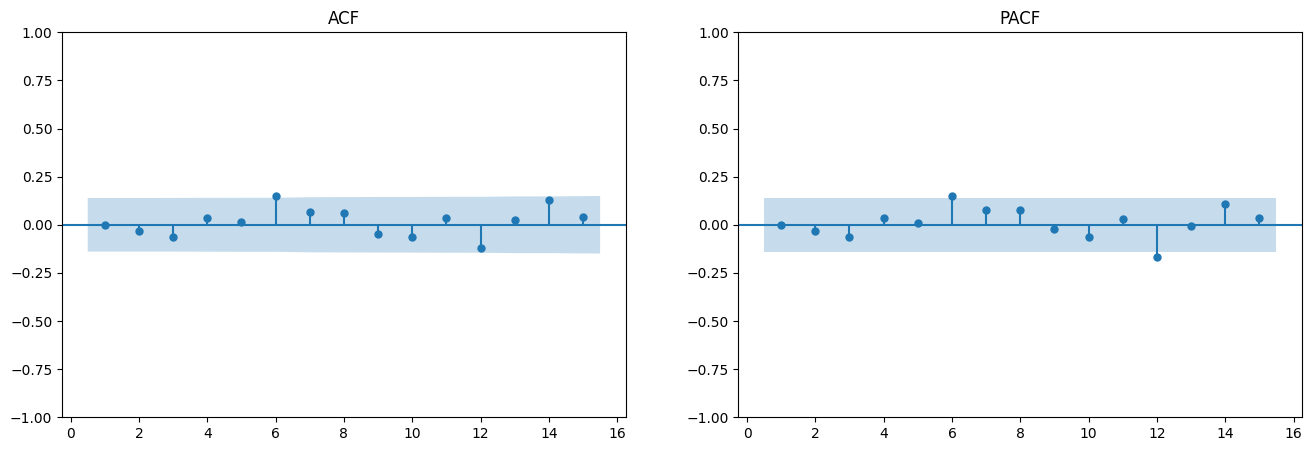

In [5]:
Y = df['weight_lbs']
x = df['food']*0.75 + df['exer']*0.25
model1 = SARIMAX(Y, order=(0,1,2), exog=x).fit(disp=False)
sf.diagnostic(model1)

In [6]:
import os
os.chdir('..')

In [7]:
pwd

'/Users/danielferreira/Documents/git/weight_control'

In [8]:
from utils.weight_analysis import wana
analysis = wana('data/weight.csv')
no_miss = analysis.df.dropna()

/Users/danielferreira/miniconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             weight_lbs   No. Observations:                  193
Model:               SARIMAX(0, 1, 2)   Log Likelihood                -291.339
Date:                Thu, 05 Jun 2025   AIC                            594.677
Time:                        22:11:48   BIC                            614.222
Sample:                    11-25-2024   HQIC                           602.593
                         - 06-05-2025                                         
Covariance Type:                  opg                                         
                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
intercept               -0.0385      0.051     -0.749      0.454      -0.139       0.062
drift                    0.0003      0.000      0.527      0.598      -0.001       0.001
food_exercis

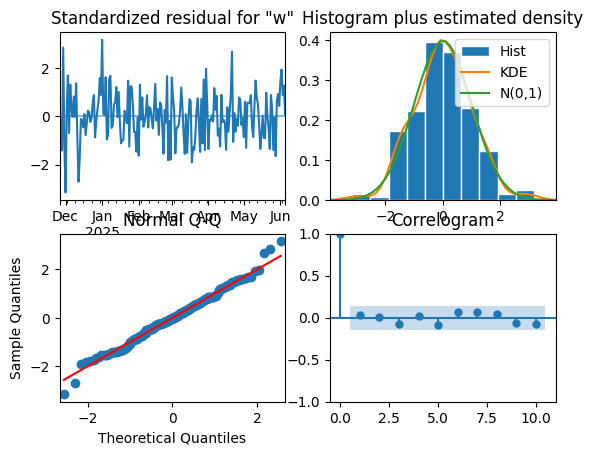

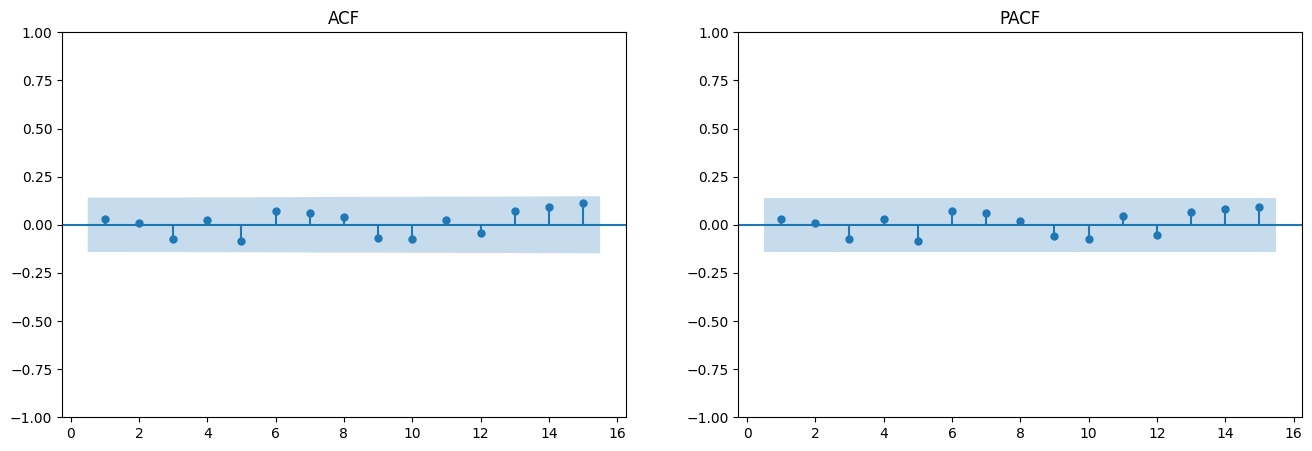

In [25]:
y = no_miss['weight_lbs']
x = no_miss['food_exercise_avg_7d']
model2 = SARIMAX(y, order=(0,1,2), exog=x, trend='ct').fit(disp=False)
sf.diagnostic(model2)

In [26]:
future_steps = 7
# first_pred_date = df.index.max()+pd.Timedelta(days=1)
# future_dates = pd.date_range(start=first_pred_date, periods=future_steps, freq="D")
x_bad = np.full(future_steps, 0.25)
x_good = np.full(future_steps, 0.75)
prediction = model2.get_forecast(steps=future_steps, exog=x_bad).predicted_mean

In [27]:
prediction

2025-06-06    157.548888
2025-06-07    157.539186
2025-06-08    157.550083
2025-06-09    157.561232
2025-06-10    157.572634
2025-06-11    157.584290
2025-06-12    157.596199
Freq: D, Name: predicted_mean, dtype: float64

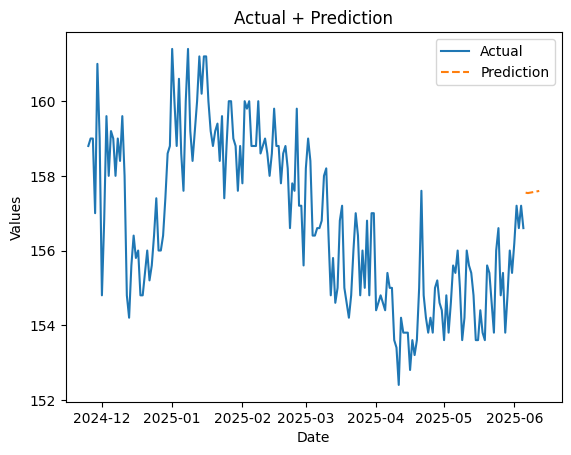

In [28]:
sf.plot_forecast(y,prediction)

In [ ]:
import json
os.chdir('forecast_model')

model_params = {
    "params": model2.params.to_dict(),
    "order": (0, 1, 2),
    "exog_mean": x.mean(),
    "exog_std": x.std()
}

with open('model_parameters.json', 'w') as f:
    json.dump(model_params, f)

In [ ]:

with open('model_parameters.json', 'r') as f:
    model_params = json.load(f)

In [ ]:
model = SARIMAX(y, order=tuple(model_params["order"]), exog=x).fit()  


In [ ]:
model.params

In [ ]:
model.params = np.array(list(model_params["params"].values()))

In [ ]:
model.params

In [ ]:
forecast_1 = model.get_forecast(steps=future_steps, exog=x_bad).predicted_mean
forecast_2 = model.get_forecast(steps=future_steps, exog=x_good).predicted_mean

sf.compare_predictions(y,[forecast_1,forecast_2], ['Bad', 'Good'])

In [ ]:
model_params

In [ ]:
def predict_scenario(exog):
    model = SARIMAX(
        endog=dummy_endog,  # Dummy endog, as we only need the coefficients
        order=tuple(model_params["order"]),
        exog=exog
    )
    model.initialize_known(
        initial_state=np.zeros(model.k_states),
        initial_state_cov=np.eye(model.k_states)
    )
    model.update(model_params["params"])
    return model.simulate(model_params["params"], steps=future_steps, exog=exog)

# Predict for both scenarios
predictions_1 = predict_scenario(x_bad)
predictions_2 = predict_scenario(x_good)

In [ ]:
print(len(y))  # Length of the dependent variable
print(len(x))  # Length of the independent variable

In [ ]:

with open('model_parameters.json', 'r') as f:
    model_params = json.load(f)


future_dates = pd.date_range(start=max, periods=future_steps, freq="D")

# Create exogenous variables for both scenarios
x_scenario_1 = np.full(future_steps, 0.25)
x_scenario_2 = np.full(future_steps, 0.75)

# Standardize exogenous variables (if needed)
x_scenario_1 = (x_scenario_1 - model_params["exog_mean"]) / model_params["exog_std"]
x_scenario_2 = (x_scenario_2 - model_params["exog_mean"]) / model_params["exog_std"]

# Initialize SARIMAX model with loaded coefficients
def predict_scenario(exog):
    model = SARIMAX(
        endog=[0],  # Dummy endog, as we only need the coefficients
        order=tuple(model_params["order"]),
        exog=exog
    )
    model.initialize_known(
        initial_state=np.zeros(model.k_states),
        initial_state_cov=np.eye(model.k_states)
    )
    model.update(model_params["params"])
    return model.simulate(model_params["params"], steps=future_steps, exog=exog)

# Predict for both scenarios
predictions_1 = predict_scenario(x_scenario_1)
predictions_2 = predict_scenario(x_scenario_2)

# Plot predictions
plt.figure(figsize=(10, 6))
plt.plot(future_dates, predictions_1, label="Scenario 1 (x=0.25)", color="blue")
plt.plot(future_dates, predictions_2, label="Scenario 2 (x=0.75)", color="orange")
plt.title("SARIMAX Predictions for Two Scenarios")
plt.xlabel("Date")
plt.ylabel("Weight (lbs)")
plt.legend()
plt.grid()
plt.show()